# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 6 de Junio. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from datetime import datetime

In [32]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


#### Carga de datos

In [4]:
covid19_data = pd.read_csv('covid_19_clean_complete.csv')
covid19_data["Date"] = pd.to_datetime(covid19_data["Date"],infer_datetime_format = True)
covid19_data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


In [6]:
covid19_data.dtypes

Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Confirmed                  int64
Deaths                     int64
Recovered                  int64
dtype: object

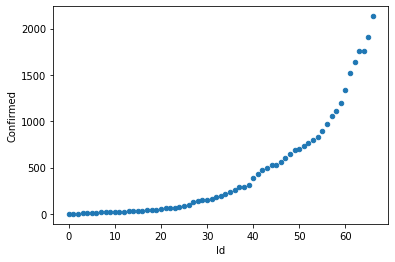

In [22]:
## Filtro de datos
GT_confirmed = covid19_data[(covid19_data["Country/Region"] == 'Guatemala') & (covid19_data["Confirmed"] > 0)].copy()

# reset de index
GT_confirmed = GT_confirmed.reset_index(drop=True)
# asignacion
GT_confirmed["Id"] = GT_confirmed.index

# Despliegue
GT_confirmed.plot.scatter(x = "Id",y="Confirmed")


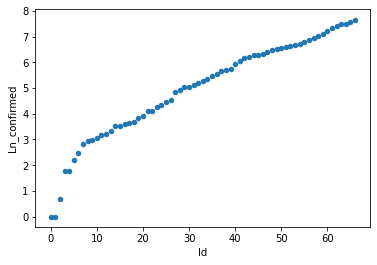

In [23]:
# Transformacion
GT_confirmed["Ln_confirmed"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed.plot.scatter(x = "Id",y="Ln_confirmed")

In [26]:
GT_confirmed.head(10)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Id,Ln_confirmed
0,NaN,Guatemala,15.7835,-90.2308,2020-03-14,1,0,0,0,0.000000
1,NaN,Guatemala,15.7835,-90.2308,2020-03-15,1,0,0,1,0.000000
2,NaN,Guatemala,15.7835,-90.2308,2020-03-16,2,1,0,2,0.693147
3,NaN,Guatemala,15.7835,-90.2308,2020-03-17,6,1,0,3,1.791759
4,NaN,Guatemala,15.7835,-90.2308,2020-03-18,6,1,0,4,1.791759
5,NaN,Guatemala,15.7835,-90.2308,2020-03-19,9,1,0,5,2.197225
6,NaN,Guatemala,15.7835,-90.2308,2020-03-20,12,1,0,6,2.484907
7,NaN,Guatemala,15.7835,-90.2308,2020-03-21,17,1,0,7,2.833213
8,NaN,Guatemala,15.7835,-90.2308,2020-03-22,19,1,0,8,2.944439
9,NaN,Guatemala,15.7835,-90.2308,2020-03-23,20,1,0,9,2.995732


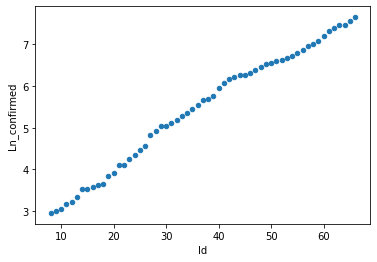

In [29]:
GT_confirmed_post24 = GT_confirmed[GT_confirmed.Date >= '2020-03-22']
GT_confirmed_post24.plot.scatter(x = "Id",y="Ln_confirmed")

In [30]:
### Objeto del modelo
class GradientDesend:
    def __init__(self,b0=0.,b1=0.):
        tf.reset_default_graph()
        self.b0 = tf.get_variable("B0",dtype=tf.float32,
                                  shape=[],initializer=tf.constant_initializer(b0))
        self.b1 = tf.get_variable("B1",dtype=tf.float32,
                                  shape=[],initializer=tf.constant_initializer(b1))
        self.error = tf.get_variable("error",dtype=tf.float32,
                                  shape=[],initializer=tf.zeros_initializer())
        
    def step(self,x,y,lr):
        # hipotesis
        yhat = tf.matmul(x,[[self.b0],[self.b1]],name="yhat") 

        error = tf.reduce_mean(tf.math.square(y - yhat) ,name="reduce_mean")/2

        grad = tf.gradients(error,[self.b0,self.b1], name = "gradients")
        
        
        local_b0 = tf.assign(self.b0, self.b0 - lr*grad[0] , name="assign_b0")
        local_b1 = tf.assign(self.b1, self.b1 - lr*grad[1] , name="assign_b1")
        local_error = tf.assign(self.error, error , name="assign_error")
        
        
        salida = tf.group(local_b0,local_b1,local_error, name="grupo")

        return salida

In [42]:
tf.reset_default_graph()


# valores iniciales
init_b0 = 0
init_b1 = 0
lr = 0.0008
iteracciones = 15

gd = GradientDesend(init_b0,init_b1)

dat_x = tf.placeholder(tf.float32,[None,2],"Value_x")
dat_y = tf.placeholder(tf.float32,[None],"Value_y")

step = gd.step(dat_x,dat_y,lr)

# se agrega unos a los valores de X para operarlo como matriz
nc = np.ones_like(GT_confirmed_post24["Id"])
x = np.hstack((np.expand_dims(GT_confirmed_post24["Id"],1),np.expand_dims(nc,1))) 


error_summary = tf.summary.scalar('error', gd.error)

with tf.train.MonitoredSession() as session:
    localdir = "logs_tarea2/gradient_" + datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" + str(lr) + "_b0="+ str(init_b0) + "_b1="+ str(init_b1)

    feed_dict = {dat_x:x, dat_y:GT_confirmed_post24["Ln_confirmed"]}
    writer = tf.summary.FileWriter(localdir , session.graph)
    for i in range(iteracciones):
        session.run(step,feed_dict=feed_dict)
        summary = session.run(error_summary,feed_dict=feed_dict)
        writer.add_summary(summary, i)

    
    
    b0,b1,error = session.run([gd.b0,gd.b1,gd.error],feed_dict=feed_dict)
    print("y = {}x + {} [{}]".format(b0,b1,error))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
y = 0.12136128544807434x + 0.014133050106465816 [3.5852770805358887]


#### Prueba del modelo para 6 de junio

Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el *6 de Junio*. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

Seria para el **Id = 84**

In [55]:
GT_confirmed_post24.tail(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Id,Ln_confirmed
62,NaN,Guatemala,15.7835,-90.2308,2020-05-15,1643,30,135,62,7.404279
63,NaN,Guatemala,15.7835,-90.2308,2020-05-16,1763,33,138,63,7.474772
64,NaN,Guatemala,15.7835,-90.2308,2020-05-17,1763,33,138,64,7.474772
65,NaN,Guatemala,15.7835,-90.2308,2020-05-18,1912,35,138,65,7.555905
66,NaN,Guatemala,15.7835,-90.2308,2020-05-19,2133,43,155,66,7.665285


In [51]:
id_pronostico = 84
estimacion_inicial = id_pronostico * b0 + b1
estimacion_inicial

10.20848102774471

In [53]:
proyeccion = np.exp(estimacion_inicial)
proyeccion

27132.323026798505

La proyeccion para el 6 de junio es **27,132**

### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
